In [1]:
import time
import pandas as pd
import numpy as np
import os
import cv2 as cv
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,\
                                    Conv2D,\
                                    MaxPooling2D,\
                                    Dropout,\
                                    Flatten
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,\
                                       ModelCheckpoint
import tensorflow as tf

In [2]:
# data loading
data = pd.DataFrame(columns=['Image', 'Symbol', 'FileName'])

for data_dir in sorted(os.listdir(r"/media/romes_papa/4116c49e-4877-48e1-938d-e7fb6cc948ea/romes_papa/Datasets/license_plates/car_nums_data")):
    for file in sorted(os.listdir(fr"/media/romes_papa/4116c49e-4877-48e1-938d-e7fb6cc948ea/romes_papa/Datasets/license_plates/car_nums_data/{data_dir}")):
        
        img_path = fr"/media/romes_papa/4116c49e-4877-48e1-938d-e7fb6cc948ea/romes_papa/Datasets/license_plates/car_nums_data/{data_dir}/{file}"
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        
        data = pd.concat([
            data,
            pd.DataFrame(data=[[img, int(data_dir), file]],
                         columns=['Image', 'Symbol', 'FileName'])
        ])

data.index = pd.RangeIndex(data.shape[0])
data

,Image,Symbol,FileName
0,"[[[229, 229, 229], [231, 231, 231], [233, 233,...",0,0.bmp
1,"[[[231, 231, 231], [230, 230, 230], [229, 229,...",0,1 (2).bmp
2,"[[[115, 115, 115], [136, 136, 136], [151, 151,...",0,1.bmp
3,"[[[102, 102, 102], [95, 95, 95], [83, 83, 83],...",0,10 (2).bmp
4,"[[[113, 113, 113], [109, 109, 109], [112, 112,...",0,10.bmp
...,...,...,...
18533,"[[[125, 125, 125], [126, 126, 126], [128, 128,...",9,95.bmp
18534,"[[[177, 177, 177], [177, 177, 177], [178, 178,...",9,96.bmp
18535,"[[[240, 240, 240], [240, 240, 240], [241, 241,...",9,97.bmp
18536,"[[[168, 168, 168], [178, 178, 178], [191, 191,...",9,98.bmp


In [3]:
# converting images to same shape
data['Height'] = data.Image.apply(lambda img: img.shape[0])
data['Width']  = data.Image.apply(lambda img: img.shape[1])

print(f'Average image height: {np.round(data.Height.mean(), 2)} px')
print(f'Average image  width: {np.round(data.Width .mean(), 2)} px')

Average image height: 53.14 px
Average image  width: 45.51 px


In [4]:
# resizing to the same shape

data.Image = data.Image.apply(lambda img: cv.resize(img, dsize=(40, 50)))

data['Height'] = data.Image.apply(lambda img: img.shape[0])
data['Width']  = data.Image.apply(lambda img: img.shape[1])

data

,Image,Symbol,FileName,Height,Width
0,"[[[229, 229, 229], [231, 231, 231], [233, 233,...",0,0.bmp,50,40
1,"[[[231, 231, 231], [230, 230, 230], [229, 229,...",0,1 (2).bmp,50,40
2,"[[[115, 115, 115], [136, 136, 136], [151, 151,...",0,1.bmp,50,40
3,"[[[102, 102, 102], [95, 95, 95], [83, 83, 83],...",0,10 (2).bmp,50,40
4,"[[[113, 113, 113], [109, 109, 109], [112, 112,...",0,10.bmp,50,40
...,...,...,...,...,...
18533,"[[[125, 125, 125], [126, 126, 126], [128, 128,...",9,95.bmp,50,40
18534,"[[[176, 176, 176], [177, 177, 177], [177, 177,...",9,96.bmp,50,40
18535,"[[[240, 240, 240], [240, 240, 240], [241, 241,...",9,97.bmp,50,40
18536,"[[[169, 169, 169], [179, 179, 179], [192, 192,...",9,98.bmp,50,40


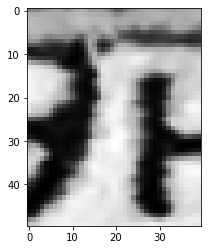

In [5]:
plt.imshow(data.loc[np.random.randint(data.shape[0]), 'Image'])

In [6]:
X = []
y = []

for image, target in zip(data.Image, data.Symbol):
    X.append(image)
    y.append(target)

X = np.array(X)
y = np.array(y)

y = utils.to_categorical(y)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
random_seed = 228
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=random_seed)

In [9]:
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (16684, 50, 40, 3)
X_test.shape = (1854, 50, 40, 3)
y_train.shape = (16684, 23)
y_test.shape = (1854, 23)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


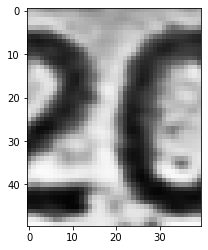

In [10]:
rand_index = np.random.randint(X_train.shape[0])
plt.imshow(X_train[rand_index])
print(y_train[rand_index])

In [11]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.01,
    width_shift_range=0.01,
    height_shift_range=0.01
)

In [12]:
# model creating
num_classes = data.Symbol.unique().shape[0]

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                 activation='relu', input_shape=(50, 40, 3)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                 activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=23, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 40, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 40, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 20, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 20, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 10, 64)        0

In [22]:
checkpoint = ModelCheckpoint('syms_recognitor.hdf5',
                             monitor='val_accuracy',
                             sasve_best_only=True,
                             verbose=1)

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [20]:
batch_size = 96
np.unique(y, axis=1).shape

(18538, 23)

In [21]:
start_time = time.time()
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    epochs=30,
                    validation_data=(X_test, y_test),
                    steps_per_epoch=(X_train.shape[0] // batch_size),
                    verbose=1,
                    callbacks=[checkpoint, learning_rate_reduction]
                    )
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/30
172/173 [============================>.] - ETA: 0s - loss: 4.0129 - accuracy: 0.7484
Epoch 00001: saving model to syms_recognitor.hdf5
173/173 [==============================] - 12s 71ms/step - loss: 3.9904 - accuracy: 0.7497 - val_loss: 0.0670 - val_accuracy: 0.9892 - lr: 0.0010
Epoch 2/30
172/173 [============================>.] - ETA: 0s - loss: 0.1121 - accuracy: 0.9742
Epoch 00002: saving model to syms_recognitor.hdf5
173/173 [==============================] - 9s 52ms/step - loss: 0.1122 - accuracy: 0.9741 - val_loss: 0.0530 - val_accuracy: 0.9898 - lr: 0.0010
Epoch 3/30
173/173 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9785
Epoch 00003: saving model to syms_recognitor.hdf5
173/173 [==============================] - 9s 52ms/step - loss: 0.0896 - accuracy: 0.9785 - val_loss: 0.0516 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 4/30
173/173 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9825
Epoch 00004: saving model to s

172/173 [============================>.] - ETA: 0s - loss: 0.0100 - accuracy: 0.9973
Epoch 00027: saving model to syms_recognitor.hdf5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1e-05.
173/173 [==============================] - 9s 53ms/step - loss: 0.0100 - accuracy: 0.9973 - val_loss: 0.0590 - val_accuracy: 0.9919 - lr: 1.5625e-05
Epoch 28/30
173/173 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9964
Epoch 00028: saving model to syms_recognitor.hdf5
173/173 [==============================] - 9s 52ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.0590 - val_accuracy: 0.9919 - lr: 1.0000e-05
Epoch 29/30
173/173 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9968
Epoch 00029: saving model to syms_recognitor.hdf5
173/173 [==============================] - 10s 55ms/step - loss: 0.0110 - accuracy: 0.9968 - val_loss: 0.0595 - val_accuracy: 0.9919 - lr: 1.0000e-05
Epoch 30/30
173/173 [==============================] - ETA